# Tutorial

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import hucira as hc

import warnings
from tqdm import TqdmWarning

warnings.simplefilter("ignore", TqdmWarning)

# The Human Cytokine Dictionary

The Human Cytokine Dictionary (hcd) can be accessed through this module. Your query data should be a transcriptomic data object in AnnData's .h5ad format with gene symbols in .var axis and metadata describing immune celltypes and experimental conditions of samples. Using the Human Cytokine Dictionary as reference, you can "look up" cytokine responses of the disease states in your own dataset.

# 1. Load input data

The two main input files for this tool are:
1. the Human Cytokine Dictionary 
2. your transcriptome data object

Explore their metadata annotation for cell types and disease condition.

In [2]:
#### Load the human cytokine dictionary

df_hcd_all = hc.load_human_cytokine_dict()

print(f"All celltypes in dictionary:\n  {df_hcd_all.celltype.unique()}")
print("\n")
print(f"All cytokines in dictionary:\n  {df_hcd_all.cytokine.unique()}")

All celltypes in dictionary:
  ['Intermediate_B_cell' 'NKT' 'CD8_Memory_T_cell' 'NK_CD56low' 'CD16_Mono'
 'NK_CD56hi' 'CD8_Naive_T_cell' 'pDC' 'ILC' 'MAIT' 'Naive_B_cell'
 'CD4_Naive_T_cell' 'Treg' 'Plasmablast' 'Granulocyte' 'B' 'CD4' 'HSPC'
 'CD8' 'CD14_Mono' 'cDC' 'CD4_Memory_T_cell' 'NK' 'Mono']


All cytokines in dictionary:
  ['4-1BBL' 'ADSF' 'APRIL' 'BAFF' 'C3a' 'C5a' 'CD27L' 'CD30L' 'CD40L' 'CT-1'
 'Decorin' 'EGF' 'EPO' 'FGF-beta' 'FLT3L' 'FasL' 'G-CSF' 'GDNF' 'GITRL'
 'GM-CSF' 'HGF' 'IFN-alpha1' 'IFN-beta' 'IFN-epsilon' 'IFN-gamma'
 'IFN-lambda1' 'IFN-lambda2' 'IFN-lambda3' 'IFN-omega' 'IGF-1'
 'IL-1-alpha' 'IL-1-beta' 'IL-10' 'IL-11' 'IL-12' 'IL-13' 'IL-15' 'IL-16'
 'IL-17A' 'IL-17B' 'IL-17C' 'IL-17D' 'IL-17E' 'IL-17F' 'IL-18' 'IL-19'
 'IL-1Ra' 'IL-2' 'IL-20' 'IL-21' 'IL-22' 'IL-23' 'IL-24' 'IL-26' 'IL-27'
 'IL-3' 'IL-31' 'IL-32-beta' 'IL-33' 'IL-34' 'IL-35' 'IL-36-alpha'
 'IL-36Ra' 'IL-4' 'IL-5' 'IL-6' 'IL-7' 'IL-8' 'IL-9' 'LIF' 'LIGHT'
 'LT-alpha1-beta2' 'LT-alpha2-beta1' '

In [3]:
#### Load the query adata object

adata = hc.load_Lupus_data()
adata

AnnData object with n_obs × n_vars = 1263676 × 30933
    obs: 'library_uuid', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'development_stage_ontology_term_id', 'disease_state', 'suspension_uuid', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'cell_type', 'disease', 'sex', 'self_reported_ethnicity', 'development_stage'
    var: 'mean_expr_raw', 'frac_expr_cells', 'mean_expr_log1p'
    uns: 'cell_type_colors', 'log1p'
    obsm: 'X_umap'

In [4]:
#### For easy workflow:
# Enter celltype column name and condition column name

your_celltype_colname = "cell_type"
your_contrast_colname = "disease_state"


# Check data size (Are the conditions you want to contrast of comparable size?)
adata.obs[your_contrast_colname].value_counts()

disease_state
managed    696626
na         486418
flare       55120
treated     25512
Name: count, dtype: int64

In [5]:
# Enrichment analysis needs two main information from query adata: cell types and disease conditions.
# They have to be chosen manually, because annotation of objects differs.

print(f"All celltypes in query data:\n  {sorted(adata.obs[your_celltype_colname].unique())}\n")
print(
    f"All experimental states (contrasts/conditions) in query data:\n  {sorted(adata.obs[your_contrast_colname].unique())}\n"
)

All celltypes in query data:
  ['B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'classical monocyte', 'conventional dendritic cell', 'lymphocyte', 'natural killer cell', 'non-classical monocyte', 'plasmablast', 'plasmacytoid dendritic cell', 'progenitor cell']

All experimental states (contrasts/conditions) in query data:
  ['flare', 'managed', 'na', 'treated']



# 2. Process and prepare input data parameters

1. Convert ENSG to gene symbols if necessary
2. Because there is no standard nomenclature for cell types, we have to manually create **"celltype_combos"**, the data container that matches the cell types of your query data to the cell types of the hcd.
3. Choose the experimental conditions of interest (**"contrasts"**)

In [6]:
#### query adata object needs to have gene symbols as adata.var.index. The Lupus data object didin't
import mygene

mg = mygene.MyGeneInfo()

results = mg.querymany(adata.var_names.tolist(), scopes="ensembl.gene", fields="symbol", species="human")

df = pd.DataFrame(results)

# Create mapping dict (fallback to Ensembl ID when symbol missing)
ensembl_to_symbol = df.set_index("query")["symbol"].fillna(df["query"]).to_dict()

adata.var["gene_symbol"] = adata.var_names.map(ensembl_to_symbol)
adata.var_names_make_unique()

# 1. Keep only rows with a gene symbol
keep_idx = ~adata.var["gene_symbol"].isna()
adata = adata[:, keep_idx].copy()

# 2. Identify duplicate gene symbols
dup_idx = adata.var["gene_symbol"].duplicated(keep="first")

# 3. Keep only the first occurrence of each gene symbol
adata = adata[:, ~dup_idx].copy()

# 4. Set gene_symbol as the new var index
adata.var_names = adata.var["gene_symbol"]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-30933...done.
Finished.
19 input query terms found dup hits:
	[('ENSG00000268674', 3), ('ENSG00000228044', 2), ('ENSG00000226506', 2), ('

In [7]:
#### Create celltype_combos. An input parameter for the enrichment analysis.

adata_celltypes = ["B cell", "CD8-positive, alpha-beta T cell", "classical monocyte"]
hcd_celltypes = ["B", "CD8", "CD14_Mono"]

celltype_combos = hc.create_celltype_combos(adata_celltypes, hcd_celltypes)
celltype_combos

(('B cell', 'B'),
 ('CD8-positive, alpha-beta T cell', 'CD8'),
 ('classical monocyte', 'CD14_Mono'))

In [8]:
#### Define conditions of interest:

contrasts = [("flare", "na"), ("flare", "managed")]

# 3. Run enrichment analysis

The main analysis is done by run_one_enrichment_test(), which computes enrichment scores of one query celltype and different conditions. 
This simple example returns an example of the main outcome of this cytokine enrichment score analysis. <br>

1. *run_one_enrichment_test()* returns enrichment results for one celltype and contrast.
2. *get_robust_significant_results()* returns the robust and significant results from that initial enrichment analysis.


In [9]:
#### Run enrichment analysis on a single celltype and condition:

print(f"You're running enrichment for: {celltype_combos[0]}.")

enrichment_results = hc.run_one_enrichment_test(
    adata=adata,
    df_hcd_all=df_hcd_all,
    contrasts_combo=contrasts,
    celltype_combo=celltype_combos[0],
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_expression=0.0,
)

# Look at all enrichment results (reduced view to columns of interest, not all statistics)
enrichment_results[
    [
        "celltype_combo",
        "cytokine",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

You're running enrichment for: ('B cell', 'B').


2025-12-05 14:18:18,938 [WARNING] Duplicated values found in preranked stats: 26.83% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
Using precomputed stats
flare_vs_na


2025-12-05 14:18:20,272 [WARNING] Duplicated values found in preranked stats: 27.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


flare_vs_managed


,celltype_combo,cytokine,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,B cell (B),IFN-beta,flare_vs_na,upregulated,0.84864,1.89274,0.0,0.0,0.0,0.905405
1,B cell (B),IFN-omega,flare_vs_na,upregulated,0.858347,1.85743,0.0,0.0,0.0,0.862069
2,B cell (B),IL-15,flare_vs_na,upregulated,0.808952,1.749844,0.0,0.0,0.0,0.896552
13,B cell (B),IFN-beta,flare_vs_managed,upregulated,0.763787,1.640831,0.0,0.000878,0.001,0.905405
3,B cell (B),IL-2,flare_vs_na,upregulated,0.80489,1.596076,0.0,0.000685,0.003,0.903226
4,B cell (B),IL-7,flare_vs_na,upregulated,0.782651,1.586343,0.0,0.000548,0.003,0.921053
14,B cell (B),IFN-omega,flare_vs_managed,upregulated,0.740493,1.558685,0.0,0.000439,0.001,0.862069
15,B cell (B),IL-15,flare_vs_managed,upregulated,0.725558,1.521389,0.0,0.000878,0.003,0.896552
16,B cell (B),IL-2,flare_vs_managed,upregulated,0.710675,1.386523,0.007439,0.013828,0.057,0.903226
17,B cell (B),IL-7,flare_vs_managed,upregulated,0.683752,1.365634,0.006316,0.016857,0.084,0.921053


In [10]:
#### Lastly, get robust and significant results from all_enrichment_results

robust_results_dict = hc.get_robust_significant_results(
    results=enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Contrast:flare_vs_na


celltype_combo,B cell (B)
cytokine,
CD40L,0.869349
IFN-beta,1.892740
IFN-gamma,1.044915
IFN-omega,1.857430
IL-1-beta,0.975622
IL-10,-0.914797
IL-13,1.008666
IL-15,1.749844
IL-2,1.596076


Contrast:flare_vs_managed


celltype_combo,B cell (B)
cytokine,
CD40L,1.042436
IFN-beta,1.640831
IFN-gamma,0.831735
IFN-omega,1.558685
IL-1-beta,1.056444
IL-10,-0.927323
IL-13,1.091181
IL-15,1.521389
IL-2,1.386523


# 4. Visualization of results


 *run_all_enrichment_test()* iterates the enrichment analysis over several cell types and gene set thresholds for the enrichment analysis, resuting in more robust results. The output is ideal for visualization of:

1. Heatmaps, representing normalized enrichment scores and significant annotations.
2. Cell-cell communication plot, representing cell communication through cytokines.

In [11]:
#### Run more robust enrichment analysis on a several celltypes and conditions:

all_enrichment_results = hc.run_all_enrichment_test(
    adata=adata,
    df_hcd_all=df_hcd_all,
    contrasts_combo=contrasts,
    celltype_combos=celltype_combos,
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_lfc=[0.8, 1],
    threshold_expression=[0.05],
)

# Look at all enrichment results (reduced view to columns of interest, not all statistics)
all_enrichment_results[
    [
        "celltype_combo",
        "cytokine",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_managed


,celltype_combo,cytokine,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,"CD8-positive, alpha-beta T cell (CD8)",IL-2,flare_vs_na,upregulated,0.782588,2.998397,0.0,0.0,0.0,0.360000
0,"CD8-positive, alpha-beta T cell (CD8)",IL-15,flare_vs_na,upregulated,0.772322,2.959019,0.0,0.0,0.0,0.313253
1,"CD8-positive, alpha-beta T cell (CD8)",IL-2,flare_vs_na,upregulated,0.82005,2.859475,0.0,0.0,0.0,0.347305
1,"CD8-positive, alpha-beta T cell (CD8)",IFN-omega,flare_vs_na,upregulated,0.802425,2.855352,0.0,0.0,0.0,0.230769
2,"CD8-positive, alpha-beta T cell (CD8)",IFN-beta,flare_vs_na,upregulated,0.800913,2.808532,0.0,0.0,0.0,0.227848
...,...,...,...,...,...,...,...,...,...,...
4,classical monocyte (CD14_Mono),Leptin,flare_vs_na,upregulated,-0.681604,-1.788927,0.008902,0.04492,0.027439,0.347826
23,classical monocyte (CD14_Mono),IL-3,flare_vs_managed,upregulated,-0.49328,-1.815102,0.0,0.016135,0.01232,0.153584
18,classical monocyte (CD14_Mono),IL-3,flare_vs_managed,upregulated,-0.573512,-1.915388,0.0,0.007435,0.00528,0.144279
17,classical monocyte (CD14_Mono),GM-CSF,flare_vs_managed,upregulated,-0.56088,-2.010597,0.0,0.005948,0.002112,0.142373


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Contrast:flare_vs_na


celltype_combo,B cell (B),"CD8-positive, alpha-beta T cell (CD8)",classical monocyte (CD14_Mono)
cytokine,,,
C5a,NaN,NaN,0.842489
CD40L,1.180408,NaN,NaN
GM-CSF,NaN,NaN,-1.678280
IFN-alpha1,NaN,2.348265,2.310958
IFN-beta,2.570711,2.764330,2.355867
IFN-gamma,NaN,2.519448,1.528101
IFN-omega,2.247730,2.831745,2.276514
IL-1-alpha,NaN,NaN,1.112410
IL-1-beta,0.013075,1.907838,1.451219


Contrast:flare_vs_managed


celltype_combo,B cell (B),"CD8-positive, alpha-beta T cell (CD8)",classical monocyte (CD14_Mono)
cytokine,,,
C5a,NaN,NaN,-1.461771
CD40L,1.429894,NaN,NaN
GM-CSF,NaN,NaN,-2.022156
IFN-alpha1,NaN,2.132560,1.801125
IFN-beta,2.405362,2.223975,1.454728
IFN-gamma,NaN,2.052437,-0.089422
IFN-omega,2.076656,2.297742,1.416213
IL-1-alpha,NaN,NaN,-1.458864
IL-1-beta,1.309567,1.314829,-1.574283


Contrast that was plotted in this example: flare_vs_na


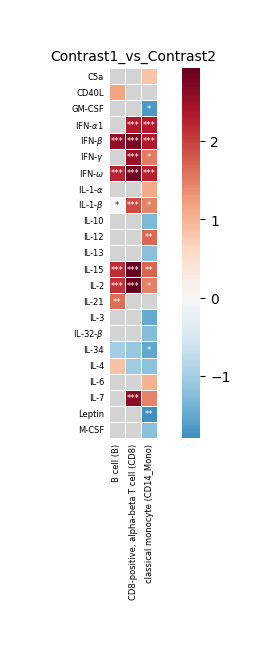

In [12]:
#### Create heatmap to visualize up-/down regulation of cytokines in all queried cell types for one contrast comparison.

robust_results_dict = hc.get_robust_significant_results(
    results=all_enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)


contrast_one = all_enrichment_results.contrast.unique()[0]  # Can be looked up manually
print(f"Contrast that was plotted in this example: {contrast_one}")

hc.plot_significant_results(
    results_pivot=robust_results_dict[contrast_one][0],
    df_annot=robust_results_dict[contrast_one][1],
    fontsize=6,
    save_fig=False,
    fig_path="",
)

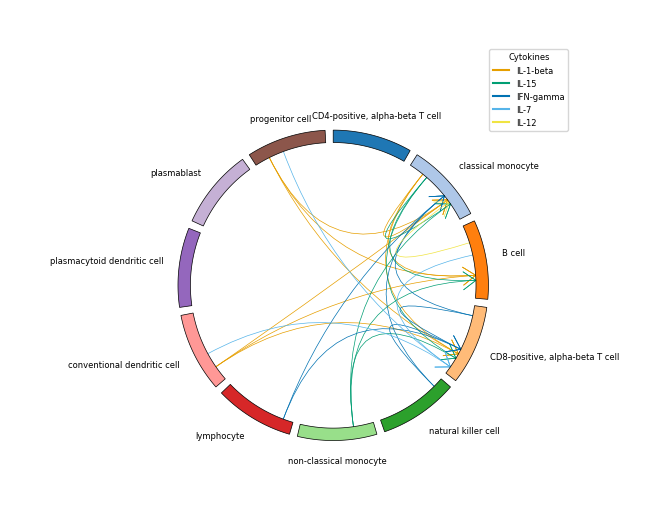

In [13]:
#### Cell-cell communication


cytokine_info = pd.read_excel(
    "/home/icb/jenni.liu/projects/cytokine_dict_folder/20250125_cytokine_info_with_functional_classification_LV.xlsx"
)
# cytokine_info = hc.load_cytokine_info()
expression_threshold = 0.1 / 10_000  # = 100 TPM
expression_threshold = np.log2((expression_threshold) + 1)

# Compute cytokine senders and receivers per cell type.
df_senders, df_receivers = hc.get_all_senders_and_receivers(
    adata=adata,
    cytokine_info=cytokine_info,
    cytokine_list=robust_results_dict[contrast_one][2].cytokine.unique(),
    celltype_colname=your_celltype_colname,
    sender_pvalue_threshold=0.1,
    receiver_mean_X_threshold=0,
)

# Plots cell-cell communication
legend_handles, legend_labels = hc.plot_communication(
    df_src=df_senders,
    df_tgt=df_receivers,
    frac_expressing_cells_sender=0,
    frac_expressing_cells_receiver=0,
    mean_cytokine_gene_expression_sender=expression_threshold,
    mean_cytokine_gene_expression_receiver=expression_threshold,
    df_enrichment=robust_results_dict[contrast_one][2],
    all_celltypes=np.array(adata.obs[your_celltype_colname].unique()),
    show_legend=True,
    figsize=(6, 7),
    lw=0.5,
    fontsize=6,
    bbox_to_anchor=(1.1, 1.1),
    loc="center",
)

In [14]:
## --END-- ##